# Libraries

In [1]:
# Standards
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Boosted Decision Tree (BDT)
import lightgbm as lgb

# Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

# Prework

## Loading data

In [3]:
data_all = pd.read_hdf("ATLAS_electrons.h5").sample(5_000)
display(data_all)

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge,p_Truth_isElectron,p_Truth_Energy
134086,34.500000,0.154677,0.410933,0.066823,0.011344,0.774599,0.698749,0.206238,0.199334,-0.070613,...,30236.966797,3366.861572,5073.538086,10543.523438,20197.898438,-0.801276,1.570494,-1.0,0,26539.658203
120880,32.500000,0.156951,0.267741,0.058421,0.010959,0.896160,0.677893,0.325421,0.179039,-0.168800,...,134025.500000,8863.776367,0.000000,32941.941406,26648.359375,-2.005269,-2.254137,-1.0,0,94864.054688
110325,36.500000,0.125611,0.400872,0.006232,0.010696,0.611216,0.948731,0.951825,0.386603,-0.160515,...,16692.462891,108.372177,1905.050049,10546.030273,13928.203125,0.476465,-1.903127,-1.0,0,15227.309570
126468,29.490000,0.447125,0.572018,0.016436,0.009901,0.956013,0.919375,0.925996,0.137491,-0.015844,...,49360.843750,507.337891,3420.308594,8403.100586,36980.718750,-1.226702,-1.633282,-1.0,0,71416.453125
85133,20.490000,0.118077,0.183818,0.053492,0.011206,0.805784,0.904773,0.818525,0.128268,0.170261,...,119204.500000,6349.770020,75.731728,16969.363281,38675.160156,-1.832805,2.595354,1.0,0,125926.242188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152474,25.490000,0.216492,0.241176,0.019488,0.010508,0.871788,0.854299,0.017067,0.448763,-0.074790,...,7614.664551,635.869080,1782.213623,6988.985352,16568.238281,-0.196497,-2.014431,1.0,0,17685.685547
65467,44.490002,1.314058,1.751989,0.138359,0.012327,0.631336,0.869856,0.079705,0.290848,-0.154544,...,46696.296875,11682.930664,1124.867188,18270.298828,18608.656250,1.841919,1.228554,1.0,0,55313.785156
143943,41.490002,0.333781,0.385264,-0.002207,0.006813,0.855020,0.706431,0.000000,0.000000,-0.229270,...,34500.332031,362.464172,11157.020508,9332.349609,25418.181641,-1.438207,-1.348827,1.0,0,55929.617188
16739,48.500000,-0.000496,-0.008913,0.007826,0.010758,0.959069,0.949143,0.904615,0.335883,-0.026884,...,46124.656250,360.648621,7646.427246,26771.441406,32607.359375,1.707869,-2.466027,-1.0,1,88518.281250


## Split data into labels and features

In [4]:
best_features = ['p_Rhad','p_sigmad0','p_TRTPID','p_deltaEta1','p_etcone20','p_numberOfInnermostPixelHits',
                 'p_Rhad1','pX_f3core','p_dPOverP','p_d0','pX_E3x5_Lr1','p_deltaPhiRescaled2','pX_deltaEta2',
                 'p_Reta','pX_topoetcone20','p_etcone30','pX_MultiLepton','p_Eratio','p_f3','pX_topoetcone40'][:10]

yelectron = data_all.pop("p_Truth_isElectron")
yenergy = data_all.pop("p_Truth_Energy")
X = data_all[best_features]

# Classification

## By hand

## LightGBM

First we split the data into training, validation, and test sets.

In [5]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X,yelectron,
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,
                                            test_size=0.25,random_state=314)

In [6]:
param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'unbalanced_sets': True,
    'num_leaves': 475,
    'learning_rate': 0.0127,
    'feature_fraction': 0.49,
    'bagging_fraction': 0.957,
    'bagging_freq': 29,
    'min_child_samples': 7,
}

lgb_model = lgb.LGBMClassifier(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10)])

[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Info] Number of positive: 859, number of negative: 3141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Numb

LGBMClassifier(bagging_fraction=0.957, bagging_freq=29, feature_fraction=0.49,
               learning_rate=0.0127, metric='binary_logloss',
               min_child_samples=7, n_estimators=1000, num_leaves=475,
               objective='binary', random_state=42, unbalanced_sets=True)

[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957


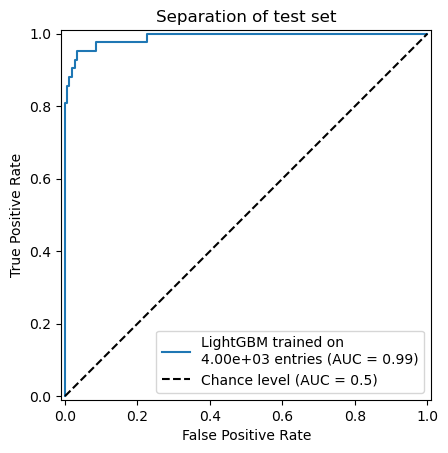

In [7]:
display_roc = RocCurveDisplay.from_predictions(
    ytest,
    ypred:= lgb_model.predict_proba(Xtest)[:,1],
    name=f"LightGBM trained on\n{len(ytrain):2.2e} entries",
    plot_chance_level=True,
)

_ = display_roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Separation of test set"
)

By inspecting the model, we see that not all features are equally important. We also see, that the model didn't get to overtrain.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

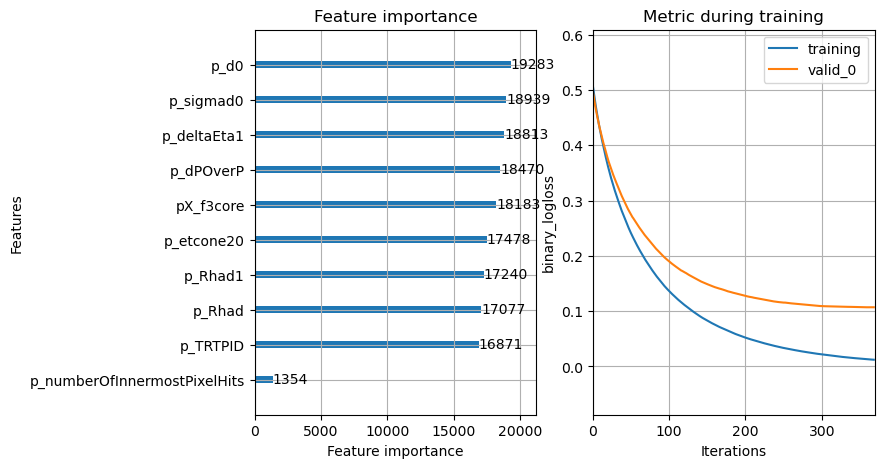

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
lgb.plot_metric(lgb_model,ax=ax[1])
lgb.plot_importance(lgb_model,ax=ax[0],max_num_features=40)

# Regression

## By hand

# LightGBM

As before we start by separating the data into sets for training, testing, and validating.

In [9]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X.loc[yelectron == 1],yenergy[yelectron==1], #Only train on particles that are actually electrons
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,test_size=0.25,random_state=314)

In [10]:
param = {
    'objective': 'regression',
    'unbalanced_sets': True,
    'num_leaves': 298,
    'learning_rate': 0.045,
    'feature_fraction': 0.64,
    'bagging_fraction': 0.97,
    'bagging_freq': 5,
    'min_child_samples': 2,
}

lgb_model = lgb.LGBMRegressor(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10)])

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2285
[LightGBM] [Info] Number of data points in the train set: 844, number of used features: 10
[LightG

LGBMRegressor(bagging_fraction=0.97, bagging_freq=5, feature_fraction=0.64,
              learning_rate=0.045, min_child_samples=2, n_estimators=1000,
              num_leaves=298, objective='regression', random_state=42,
              unbalanced_sets=True)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

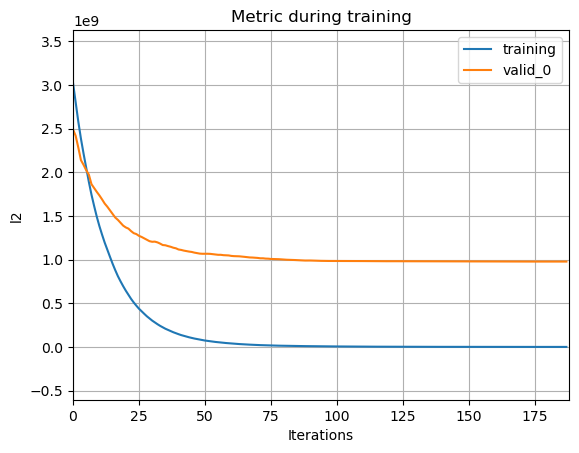

In [11]:
lgb.plot_metric(lgb_model)

In [12]:
energy_pred = lgb_model.predict(Xtest)

rel_dev = (energy_pred-ytest)/ytest

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97


[(-2.0, 5.0), Text(0, 0.5, 'Counts/53'), Text(0.5, 0, 'Relative deviation')]

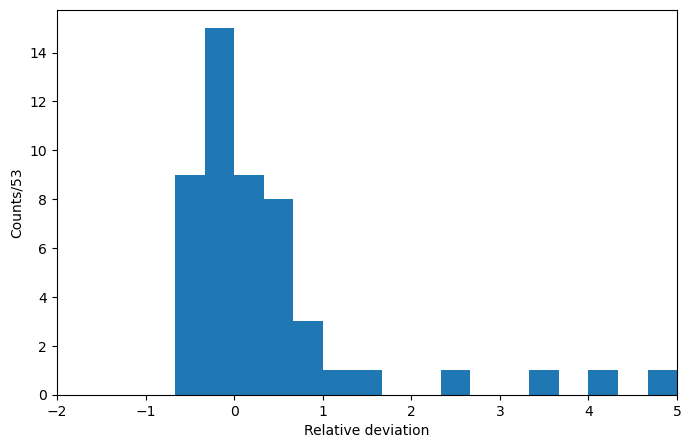

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
bins = np.linspace(-5,5,31)

xlabel = f"Relative deviation"
if largest:=np.min(rel_dev) > 5:
    bins[-1] = largest #Note that the last bin contains everything less than -5
    xlabel += f" - Zoomed in from {bins[0]:.2f}"
    
ax.hist(rel_dev, bins = bins)
ax.set(xlim=(-2,5),
      ylabel=f"Counts/{len(ytest)}",
      xlabel=xlabel)